In [10]:
import os
import json
import shutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pycocotools.coco import COCO
from collections import defaultdict
import torch
import torch.utils.data as data
from PIL import Image
import torchvision.transforms as transforms
import random
from sklearn.model_selection import train_test_split

# 1. Filter Classes and Re-label Data

In [ ]:
def print_IDs(path):
    with open(path, "r") as f:
        coco_data = json.load(f)

    categories = {c["id"]: c["name"] for c in coco_data["categories"]}
    print(categories)

In [ ]:
print_IDs("/mnt/datassd0/coco-2017/annotations/instances_train2017.json")

In [ ]:
print_IDs("/mnt/datassd0/coco-2017/annotations/instances_val2017.json")

In [ ]:
################# KEEP IMAGES WITH 0 ANNOTATIONS AND ASSIGN "UNLABELED" CATEGORY #################
def filter_and_relabel_coco(input_json, output_json, dropped_classes):
    
    # Load the original COCO dataset
    with open(input_json, "r") as f:
        coco_data = json.load(f)

    # Get a mapping of original category IDs to names
    original_categories = {c["id"]: c["name"] for c in coco_data["categories"]}

    # Select only categories **not in dropped_classes** and relabel them from 1 to N
    selected_categories = [c for c in coco_data["categories"] if c["name"] not in dropped_classes]
    selected_cat_ids = {c["id"]: i + 1 for i, c in enumerate(selected_categories)}  # Start from 1 instead of 0

    # Add an "unlabeled" category at the end
    unlabeled_id = len(selected_categories) + 1
    new_categories = [{"id": new_id, "name": c["name"]} for new_id, c in enumerate(selected_categories, start=1)]
    new_categories.append({"id": unlabeled_id, "name": "unlabeled"})  # Add "unlabeled" category

    new_annotations = []
    image_id_to_annotations = {}

    # Process annotations and keep only non-dropped categories
    for ann in coco_data["annotations"]:
        if ann["category_id"] in selected_cat_ids:
            ann["category_id"] = selected_cat_ids[ann["category_id"]]  # Re-map category ID
            new_annotations.append(ann)
            image_id_to_annotations.setdefault(ann["image_id"], []).append(ann)

    # Get all image IDs that exist in the dataset
    all_image_ids = {img["id"] for img in coco_data["images"]}

    # Identify images that have no remaining annotations
    images_without_annotations = all_image_ids - set(image_id_to_annotations.keys())

    # Assign a dummy "unlabeled" annotation to images that lost all annotations
    for img_id in images_without_annotations:
        new_annotations.append({
            "id": len(new_annotations) + 1,  # Unique annotation ID
            "image_id": img_id,
            "category_id": unlabeled_id,  # Assign to "unlabeled"
            "bbox": [0, 0, 1, 1],  # Placeholder bounding box
            "area": 1,
            "iscrowd": 0
        })

    # Keep all images, even if they had 0 annotations
    new_images = coco_data["images"]

    new_coco_data = {
        "info": coco_data.get("info", {}),
        "licenses": coco_data.get("licenses", []),
        "images": new_images,
        "annotations": new_annotations,
        "categories": new_categories,
    }

    with open(output_json, "w") as f:
        json.dump(new_coco_data, f, indent=None)

    print(f"Filtered COCO dataset saved as {output_json}")

# Define dropped classes
dropped_classes = [
    "person", # Highest class label
    "wine glass", "cup", "bicycle", "potted plant", "bowl", # Repetitive classes
    "snowboard", "surfboard", "baseball glove", "baseball bat", # Sports category (highly associated with person)
    "tennis racket", "kite", "frisbee", "skis", "sports ball", "skateboard", # Sports category (highly associated with person)
    "backpack", "umbrella", "handbag", "tie", "suitcase", # Accessories category (highly associated with person)
    "car", "motorcycle", "airplane", "bus", "train", "truck", # Vehicles category (highly associated with person)
    "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", # Outdoor objects
    "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", # Outdoor wild animals
]


# Apply the filtering function
filter_and_relabel_coco("/mnt/datassd0/coco-2017/annotations/instances_train2017.json", "/mnt/datassd0/coco-2017/annotations/instances_train2017_filtered.json", dropped_classes)
filter_and_relabel_coco("/mnt/datassd0/coco-2017/annotations/instances_val2017.json", "/mnt/datassd0/coco-2017/annotations/instances_val2017_filtered.json", dropped_classes)

In [ ]:
print_IDs("/mnt/datassd0/coco-2017/annotations/instances_train2017_filtered.json")

In [ ]:
print_IDs("/mnt/datassd0/coco-2017/annotations/instances_val2017_filtered.json")

# 2. Split Data

In [ ]:
def combine_and_split_coco_with_images(
    train_json, val_json,
    output_dir,
    original_train_dir, original_val_dir,
    split_mode="train_val",                # "train_val" or "train_val_test"
    split_ratios=(0.8, 0.2),               # (train, val) or (train, val, test)
    random_seed=42
):
    os.makedirs(output_dir, exist_ok=True)

    # Load original datasets
    with open(train_json, "r") as f:
        train_data = json.load(f)
    with open(val_json, "r") as f:
        val_data = json.load(f)

    # Combine images and annotations
    all_images = train_data["images"] + val_data["images"]
    all_annotations = train_data["annotations"] + val_data["annotations"]
    categories = train_data["categories"]

    # Map image_id → annotations
    image_id_to_annotations = {img["id"]: [] for img in all_images}
    for ann in all_annotations:
        image_id_to_annotations[ann["image_id"]].append(ann)

    all_image_ids = list(image_id_to_annotations.keys())
    image_labels = [
        (anns[0]["category_id"] if anns else -1)
        for anns in [image_id_to_annotations[iid] for iid in all_image_ids]
    ]

    def split_data(ids_set):
        imgs = [img for img in all_images if img["id"] in ids_set]
        anns = [ann for ann in all_annotations if ann["image_id"] in ids_set]
        return imgs, anns

    def save_json(images, annotations, name):
        data = {
            "info": train_data.get("info", {}),
            "licenses": train_data.get("licenses", []),
            "images": images,
            "annotations": annotations,
            "categories": categories,
        }
        out_path = os.path.join(output_dir, f"instances_{name}.json")
        with open(out_path, "w") as f:
            json.dump(data, f, indent=None)
        return out_path

    # def copy_images(image_list, destination_dir):
    #     os.makedirs(destination_dir, exist_ok=True)
    #     for img in image_list:
    #         file_name = img["file_name"]
    #         src_path = os.path.join(original_train_dir, file_name)
    #         if not os.path.exists(src_path):
    #             src_path = os.path.join(original_val_dir, file_name)
    #         if not os.path.exists(src_path):
    #             print(f"Warning: {file_name} not found.")
    #             continue
    #         dst_path = os.path.join(destination_dir, file_name)
    #         shutil.copy2(src_path, dst_path)

    # === SPLITTING LOGIC ===
    if split_mode == "train_val":
        assert len(split_ratios) == 2, "split_ratios must be (train, val) for train_val mode"
        train_ratio = split_ratios[0]

        train_ids, val_ids = train_test_split(
            all_image_ids,
            train_size=train_ratio,
            stratify=image_labels,
            random_state=random_seed
        )

        train_imgs, train_anns = split_data(set(train_ids))
        val_imgs, val_anns = split_data(set(val_ids))

        save_json(train_imgs, train_anns, "train")
        save_json(val_imgs, val_anns, "test")

        # If you want to copy the images to the output directory, uncomment the following lines
        # copy_images(train_imgs, os.path.join(output_dir, "train"))
        # copy_images(val_imgs, os.path.join(output_dir, "test"))

        print(f"[Train/Val] Train: {len(train_imgs)}, Test: {len(val_imgs)}")

    elif split_mode == "train_val_test":
        assert len(split_ratios) == 3, "split_ratios must be (train, val, test) for train_val_test mode"
        train_ratio, val_ratio, test_ratio = split_ratios
        assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Ratios must sum to 1"

        # Step 1: Train vs Temp (Val + Test)
        train_ids, temp_ids, train_labels, temp_labels = train_test_split(
            all_image_ids,
            image_labels,
            train_size=train_ratio,
            stratify=image_labels,
            random_state=random_seed
        )

        # Step 2: Val vs Test from Temp
        val_relative = val_ratio / (val_ratio + test_ratio)
        val_ids, test_ids = train_test_split(
            temp_ids,
            train_size=val_relative,
            stratify=temp_labels,
            random_state=random_seed
        )

        train_imgs, train_anns = split_data(set(train_ids))
        val_imgs, val_anns = split_data(set(val_ids))
        test_imgs, test_anns = split_data(set(test_ids))

        save_json(train_imgs, train_anns, "train")
        save_json(val_imgs, val_anns, "val")
        save_json(test_imgs, test_anns, "test")

        # If you want to copy the images to the output directory, uncomment the following lines
        # copy_images(train_imgs, os.path.join(output_dir, "train"))
        # copy_images(val_imgs, os.path.join(output_dir, "val"))
        # copy_images(test_imgs, os.path.join(output_dir, "test"))

        print(f"[Train/Val/Test] Train: {len(train_imgs)}, Val: {len(val_imgs)}, Test: {len(test_imgs)}")

    else:
        raise ValueError("Invalid split_mode. Use 'train_val' or 'train_val_test'.")


In [ ]:
combine_and_split_coco_with_images(
    train_json="/mnt/datassd0/coco-2017/annotations/instances_train2017_filtered.json",
    val_json="/mnt/datassd0/coco-2017/annotations/instances_val2017_filtered.json",
    output_dir="/mnt/datassd0/coco-2017/output_balanced_80_20",
    original_train_dir="/mnt/datassd0/coco-2017/images/train2017",
    original_val_dir="/mnt/datassd0/coco-2017/images/val2017",
    split_mode="train_val",
    split_ratios=(0.8, 0.2)
)

In [ ]:
combine_and_split_coco_with_images(
    train_json="/mnt/datassd0/coco-2017/annotations/instances_train2017_filtered.json",
    val_json="/mnt/datassd0/coco-2017/annotations/instances_val2017_filtered.json",
    output_dir="/mnt/datassd0/coco-2017/output_balanced_70_15_15",
    original_train_dir="/mnt/datassd0/coco-2017/images/train2017",
    original_val_dir="/mnt/datassd0/coco-2017/images/val2017",
    split_mode="train_val_test",
    split_ratios=(0.7, 0.15, 0.15)
)

### This Cell Splits Checks the distribution (histogram) for train/val annotations

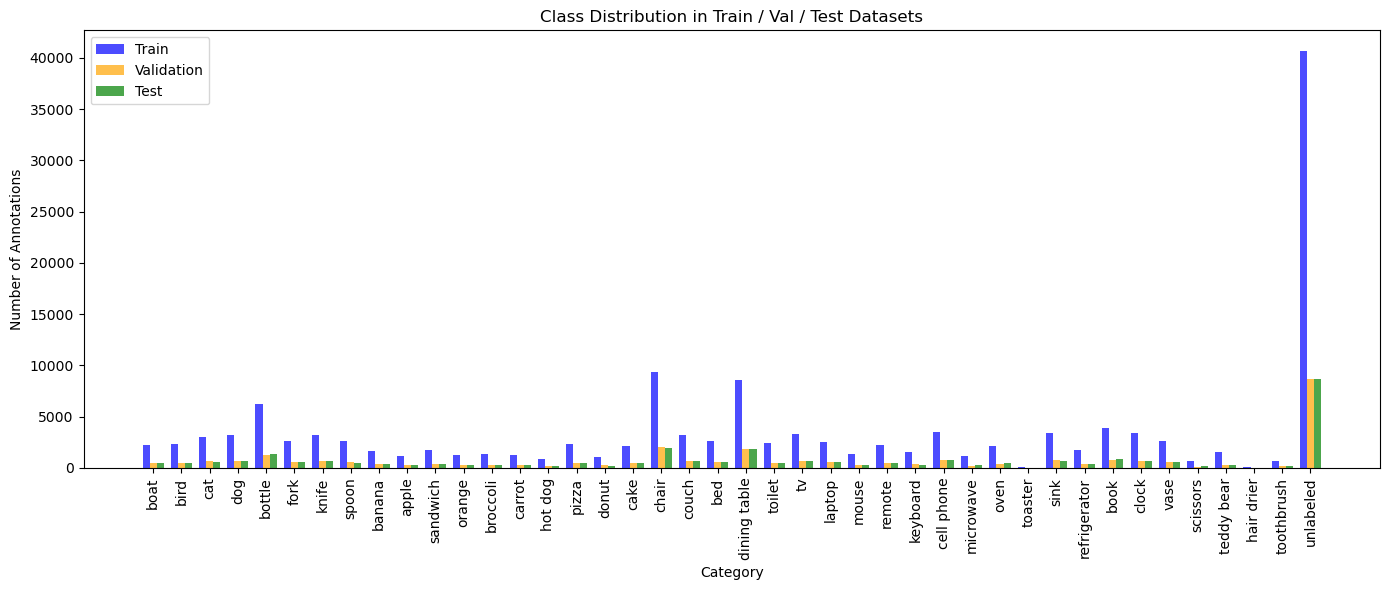

In [11]:
# Load the JSON files
with open("/mnt/datassd0/coco-2017/output_balanced_70_15_15/instances_train.json", "r") as f:
    train_data = json.load(f)

with open("/mnt/datassd0/coco-2017/output_balanced_70_15_15/instances_val.json", "r") as f:
    val_data = json.load(f)

with open("/mnt/datassd0/coco-2017/output_balanced_70_15_15/instances_test.json", "r") as f:
    test_data = json.load(f)

# Create a mapping from category ID to name (assumes same categories in all files)
category_mapping = {cat["id"]: cat["name"] for cat in train_data["categories"]}

# Initialize counts for all three sets
train_counts = {cid: 0 for cid in category_mapping}
val_counts   = {cid: 0 for cid in category_mapping}
test_counts  = {cid: 0 for cid in category_mapping}

# Count annotations - track unique image_id, category_id pairs
train_unique_pairs = set()
val_unique_pairs = set()
test_unique_pairs = set()

for ann in train_data["annotations"]:
    pair = (ann["image_id"], ann["category_id"])
    if pair not in train_unique_pairs:
        train_counts[ann["category_id"]] += 1
        train_unique_pairs.add(pair)

for ann in val_data["annotations"]:
    pair = (ann["image_id"], ann["category_id"])
    if pair not in val_unique_pairs:
        val_counts[ann["category_id"]] += 1
        val_unique_pairs.add(pair)

for ann in test_data["annotations"]:
    pair = (ann["image_id"], ann["category_id"])
    if pair not in test_unique_pairs:
        test_counts[ann["category_id"]] += 1
        test_unique_pairs.add(pair)


# Prepare for plotting
sorted_ids   = sorted(category_mapping.keys())
sorted_names = [category_mapping[cid] for cid in sorted_ids]
train_values = [train_counts.get(cid, 0) for cid in sorted_ids]
val_values   = [val_counts.get(cid, 0) for cid in sorted_ids]
test_values  = [test_counts.get(cid, 0) for cid in sorted_ids]

bar_width = 0.25
indices = np.arange(len(sorted_ids))

plt.figure(figsize=(14, 6))

# Plot bars
plt.bar(indices, train_values, bar_width, label="Train", alpha=0.7, color="blue")
plt.bar(indices + bar_width, val_values, bar_width, label="Validation", alpha=0.7, color="orange")
plt.bar(indices + 2 * bar_width, test_values, bar_width, label="Test", alpha=0.7, color="green")

# Labels and aesthetics
plt.xlabel("Category")
plt.ylabel("Number of Annotations")
plt.title("Class Distribution in Train / Val / Test Datasets")
plt.xticks(indices + bar_width, sorted_names, rotation=90)
plt.legend()
plt.tight_layout()

# Show plot
plt.show()

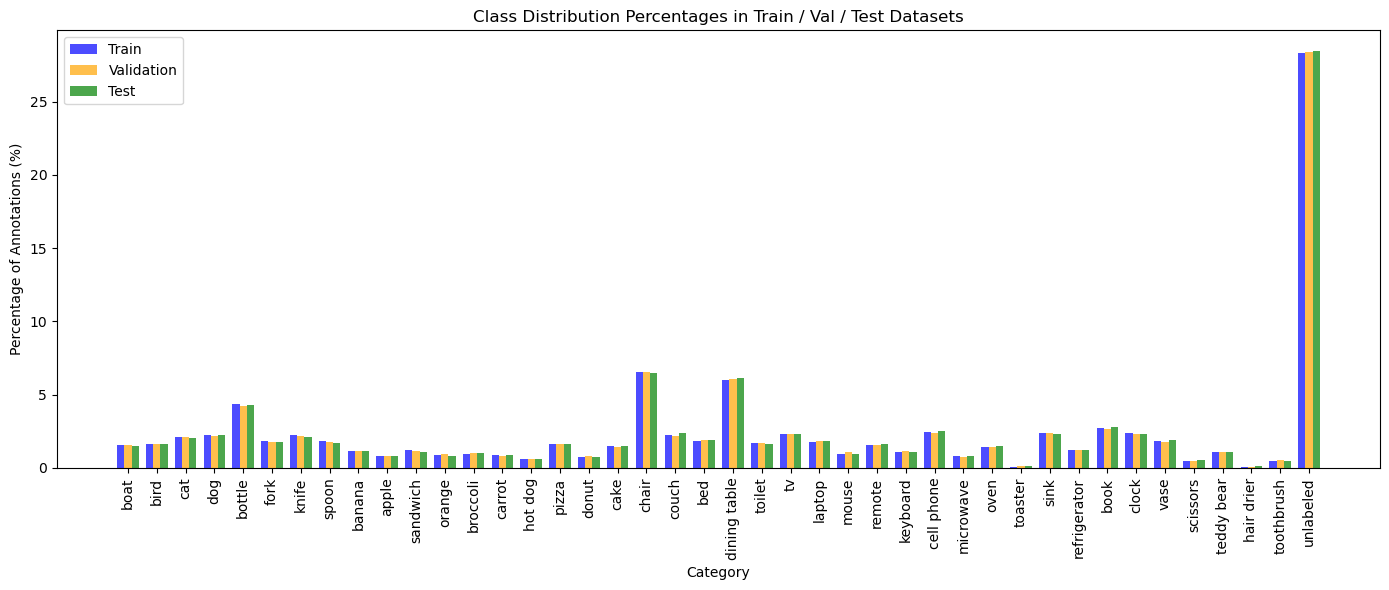

In [12]:
# Calculate percentages for each dataset
total_train = sum(train_values)
total_val = sum(val_values)
total_test = sum(test_values)

train_percentages = [count / total_train * 100 for count in train_values]
val_percentages = [count / total_val * 100 for count in val_values]
test_percentages = [count / total_test * 100 for count in test_values]

# Create a new figure for percentages
plt.figure(figsize=(14, 6))

# Plot percentage bars
plt.bar(indices, train_percentages, bar_width, label="Train", alpha=0.7, color="blue")
plt.bar(indices + bar_width, val_percentages, bar_width, label="Validation", alpha=0.7, color="orange")
plt.bar(indices + 2 * bar_width, test_percentages, bar_width, label="Test", alpha=0.7, color="green")

# Labels and aesthetics
plt.xlabel("Category")
plt.ylabel("Percentage of Annotations (%)")
plt.title("Class Distribution Percentages in Train / Val / Test Datasets")
plt.xticks(indices + bar_width, sorted_names, rotation=90)
plt.legend()
plt.tight_layout()

# Show plot
plt.show()


# 3. Prepare Dataset

In [ ]:
class CustomCocoDataset(data.Dataset):
    def __init__(self, image_dir, anno_path, labels_path=None, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.labels_path = labels_path

        # Load COCO JSON
        with open(anno_path, "r") as f:
            coco_data = json.load(f)

        self.images = {img["id"]: img["file_name"] for img in coco_data["images"]}
        self.annotations = coco_data["annotations"]

        # Store category names along with ID mappings
        self.category_map = {c["id"]: i for i, c in enumerate(coco_data["categories"], start=1)}
        self.category_id_to_name = {c["id"]: c["name"] for c in coco_data["categories"]}  
        self.num_classes = len(self.category_map)

        # Organize annotations by image_id
        self.image_to_annotations = {img_id: [] for img_id in self.images}
        for ann in self.annotations:
            self.image_to_annotations[ann["image_id"]].append(ann)

        # Store image IDs as dataset index
        self.image_ids = list(self.images.keys())

        # Load or generate labels
        if self.labels_path and os.path.exists(self.labels_path):
            print(f"Loading precomputed labels from {self.labels_path}...")
            self.labels = np.load(self.labels_path)
        else:
            print("No precomputed label file found. Generating labels...")
            self.labels = self.generate_labels()
            if self.labels_path:
                os.makedirs(os.path.dirname(self.labels_path), exist_ok=True)
                self.save_labels(self.labels_path)

    def generate_labels(self):
        # Generate binary encoded labels for each image and return as NumPy array.
        labels = np.zeros((len(self.image_ids), self.num_classes))
        for i, img_id in enumerate(self.image_ids):
            for ann in self.image_to_annotations[img_id]:
                category_id = ann["category_id"]
                labels[i][self.category_map[category_id] - 1] = 1  # Convert to binary
        return labels

    def save_labels(self, labels_path):
        np.save(labels_path, self.labels)
        print(f"Labels saved to {labels_path}")

    def __getitem__(self, index):
        # Loads an image and its binary encoded label.
        img_id = self.image_ids[index]
        img_path = os.path.join(self.image_dir, self.images[img_id])

        # Load image
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        # Load label from precomputed `.npy`
        label = torch.tensor(self.labels[index], dtype=torch.float32)

        return image, label

    def __len__(self):
        return len(self.image_ids)

In [ ]:
train_images = "/mnt/datassd0/coco-2017/images/all_images"
train_annotations = "/mnt/datassd0/coco-2017/output_balanced_70_15_15/instances_train.json"
train_labels_npy = "/mnt/datassd0/coco-2017/annotations/train_labels.npy"  # Path to save labels

val_images = "/mnt/datassd0/coco-2017/images/all_images"
val_annotations = "/mnt/datassd0/coco-2017/output_balanced_70_15_15/instances_val.json"
val_labels_npy = "/mnt/datassd0/coco-2017/annotations/val_labels.npy"  # Path to save labels

train_dataset = CustomCocoDataset(train_images, train_annotations, labels_path=train_labels_npy)
val_dataset = CustomCocoDataset(val_images, val_annotations, labels_path=val_labels_npy)

In [ ]:
# Find the category ID assigned to "unlabeled"
unlabeled_id = None
for cat_id, cat_name in train_dataset.category_id_to_name.items():
    if cat_name == "unlabeled":
        unlabeled_id = cat_id
        break

if unlabeled_id is None:
    raise ValueError("Error: 'unlabeled' category not found in dataset categories.")

# Count total number of images
total_images = len(train_dataset) + len(val_dataset)

# Count the number of images with no annotations or only "unlabeled" category
unlabeled_count = 0

# Count unlabeled images in the training dataset
for img_id in train_dataset.image_ids:
    annotations = train_dataset.image_to_annotations[img_id]
    
    if not annotations or all(ann["category_id"] == unlabeled_id for ann in annotations):
        unlabeled_count += 1

# Count unlabeled images in the validation dataset
for img_id in val_dataset.image_ids:
    annotations = val_dataset.image_to_annotations[img_id]
    
    if not annotations or all(ann["category_id"] == unlabeled_id for ann in annotations):
        unlabeled_count += 1

# Compute and print the percentage of unlabeled images
unlabeled_percentage = (unlabeled_count / total_images) * 100

print(f"Total images: {total_images}")
print(f"Unlabeled images: {unlabeled_count}")
print(f"Unlabeled Percentage: {unlabeled_percentage:.2f}%")

In [ ]:
# Get image and label from dataset
image, label = train_dataset[1]  

# Convert label tensor to numpy array
label_array = label.numpy()
print(label_array)

# Get names of active labels (where value is 1)
active_labels = [train_dataset.category_id_to_name[i + 1] for i in range(len(label_array)) if label_array[i] == 1]

# Convert image to PIL if it's a tensor
if isinstance(image, torch.Tensor):
    image = transforms.ToPILImage()(image)

# Display the image with label names
plt.imshow(image)
plt.axis("off")
plt.title(f"Labels: {', '.join(active_labels)}")  # Display category names instead of numbers
plt.show()